In [31]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from plot_keras_history import show_history, plot_history

import importlib
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import metrics
import pickle
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
# FONCTIONS 

def create_model_fct(model0, loss = "categorical_crossentropy", opti='rmsprop', option = True) :
    '''Création du modèle adapté à notre objectif de classification 
    en modifiant le modèle pré-entraîné passé en paramètre.'''
    
    # On garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    
    # Compléter le modèle pour qu'il fournisse les probabilités d'appartenir aux 7 catégories.
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss=loss, optimizer=opti, metrics=["accuracy"])

    if option == True :
        print(model.summary())
    
    return model
    
def image_prep_fct(list_photos, model=None) :
    '''Préparation des images pour la modélisation.'''
    
    prepared_images = []
    
    for image_num in range(len(list_photos)) :
        img = (load_img(
            path_images + list_photos[image_num], 
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        if model == 'ResNet50':
            img = resnet50.preprocess_input(img)
        elif model == 'MobileNetV2':
            img = mobilenet_v2.preprocess_input(img)
        else :
            img = vgg16.preprocess_input(img)

        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)

    return prepared_images_np

def plot_hist(hist) :
    '''Affichage de la loss et de l'accuracy en fonction des epochs.'''
    show_history(hist)
    plot_history(hist)
    plt.close()

def data_flow_fct(data, datagen, data_type=None) :
    '''Génère des lots de données augmentées.'''
    
    data_flow = datagen.flow_from_dataframe(data, directory=path_images,
                                x_col='image', y_col='label',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [33]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [34]:
df = pd.read_csv('data.csv')

In [35]:
df.head()

,Unnamed: 0,uniq_id,product_name,product_category_tree,image,description,categ_1,categ_2,categ_3,descriptions,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_bow_lem,length_dl
0,0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"['Home Furnishing', 'Curtains & Accessories', ...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,163,163,255
1,1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"['Baby Care', 'Baby Bath & Skin', 'Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Cotton Bath Towel Specifications of S...,sathiyas cotton bath towel specifications sath...,sathiyas cotton bath towel specification sathi...,sathiyas cotton bath towel specifications of s...,67,67,88
2,2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"['Baby Care', 'Baby Bath & Skin', 'Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...,164,164,258
3,3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"['Home Furnishing', 'Bed Linen', 'Bedsheets', ...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,123,123,157
4,4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"['Home Furnishing', 'Bed Linen', 'Bedsheets', ...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,164,164,236


In [36]:
le = LabelEncoder()
le.fit(df["categ_1"])
df["label"] = le.transform(df["categ_1"])

In [37]:
df.head()

,Unnamed: 0,uniq_id,product_name,product_category_tree,image,description,categ_1,categ_2,categ_3,descriptions,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_bow_lem,length_dl,label
0,0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"['Home Furnishing', 'Curtains & Accessories', ...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,163,163,255,4
1,1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"['Baby Care', 'Baby Bath & Skin', 'Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Cotton Bath Towel Specifications of S...,sathiyas cotton bath towel specifications sath...,sathiyas cotton bath towel specification sathi...,sathiyas cotton bath towel specifications of s...,67,67,88,0
2,2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"['Baby Care', 'Baby Bath & Skin', 'Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...,164,164,258,0
3,3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"['Home Furnishing', 'Bed Linen', 'Bedsheets', ...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,123,123,157,4
4,4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"['Home Furnishing', 'Bed Linen', 'Bedsheets', ...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,164,164,236,4


In [38]:
liste_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

In [39]:
path_images = 'Images/'
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


# Mobilenet

MobileNet est une architecture de réseau de neurones convolutifs optimisée pour les appareils mobiles et les applications de vision par ordinateur embarquées, qui utilise des convolutions séparables en profondeur pour minimiser le nombre de paramètres sans compromettre la précision de classification

In [40]:
# Séparation du jeu de données en jeu de train et de test
X_train_mob, X_test_mob, y_train_mob, y_test_mob = train_test_split(df['image'], df['label'], test_size=0.2, random_state=0)
print(X_train_mob.shape)
print(y_train_mob.shape)
print(X_test_mob.shape)
print(y_test_mob.shape)

(840,)
(840,)
(210,)
(210,)


In [41]:
X_train_mob = list(X_train_mob)
X_test_mob = list(X_test_mob)

In [42]:
# Traitement des images pour les rendre exploitables par l'algorithme
images_np = image_prep_fct(X_train_mob,'MobileNetV2')
print(images_np.shape)
images_np_test = image_prep_fct(X_test_mob, 'MobileNetV2')
print(images_np_test.shape)

(840, 224, 224, 3)


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [43]:
X_mob = images_np
y_mob = to_categorical(y_train_mob)

X_test_mob = images_np_test
y_test_mob = to_categorical(y_test_mob)

y_mob

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [44]:
# Séparation du jeu de train en jeu de train et de validation
X_train_mob, X_val_mob, y_train_mob, y_val_mob = train_test_split(X_mob, y_mob, stratify=y_mob, test_size=0.25, random_state=0)
X_train_mob.shape

(630, 224, 224, 3)

In [45]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model2 = create_model_fct(model)

# Création du callback
model2_save_path1 = "models/model2_mobilenet_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [46]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history2 = model2.fit(X_train_mob, y_train_mob, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val_mob, y_val_mob), verbose=1)

temps2_train_mob = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_mob))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.3560 - loss: 1.9661
Epoch 1: val_loss improved from inf to 0.72637, saving model to models/model2_mobilenet_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3700 - loss: 1.9203 - val_accuracy: 0.7667 - val_loss: 0.7264
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.8182 - loss: 0.5916
Epoch 2: val_loss improved from 0.72637 to 0.63566, saving model to models/model2_mobilenet_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8195 - loss: 0.5893 - val_accuracy: 0.7810 - val_loss: 0.6357
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8594 - loss: 0.4126
Epoch 3: val_loss did not improve from 0.63566
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8598 - loss: 0.4115 - val_accuracy: 0.8095 - val_loss: 0.6632
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9216 - loss: 0.2546
Epoch 4: val_loss improved from 0.63566 to 0.5

Après avoir entrainé le modèle, nous allons évaluer les scores de celui-ci.

On s'intéresse ici à l'accuracy et à la loss. L'accuracy est une métrique qui mesure la performance d'un modèle de classification. Elle représente la proportion de prédictions correctes faites par le modèle. La loss est une mesure qui permet d'évaluer la qualité des prédictions d'un modèle par rapport à la réalité. Elle mesure l'écart entre les prédictions du modèle et les valeurs réelles de la variable cible. Le but est de minimiser cette fonction de perte pour améliorer les performances du modèle.

Nous utiliserons ces métriques afin de comparer nos différents modèles.

In [47]:
# Scores du dernier epoch

loss_train, accuracy_train = model2.evaluate(X_train_mob, y_train_mob, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train))
print()
loss, accuracy = model2.evaluate(X_val_mob, y_val_mob, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.9968 - loss: 0.0288
Training Accuracy: 0.9968

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.8421 - loss: 0.5422
Validation Accuracy:  0.8095


In [48]:
# Scores de l'epoch optimal

model2.load_weights(model2_save_path1)

loss_train_mob, accuracy_train_mob = model2.evaluate(X_train_mob, y_train_mob, verbose=False)
print("Training Accuracy :  {:.4f}".format(accuracy_train_mob))

temps1=time.time()

loss_val_mob, accuracy_val_mob = model2.evaluate(X_val_mob, y_val_mob, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_mob))

temps2_val_mob = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_mob))

temps1=time.time()

loss_test_mob, accuracy_test_mob = model2.evaluate(X_test_mob, y_test_mob, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_mob))

temps2_test_mob = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_mob))

Training Accuracy :  0.9810
Validation Accuracy :  0.8333
Temps validation : 2.68 secondes
Test Accuracy       :  0.8048
Temps test : 2.8 secondes


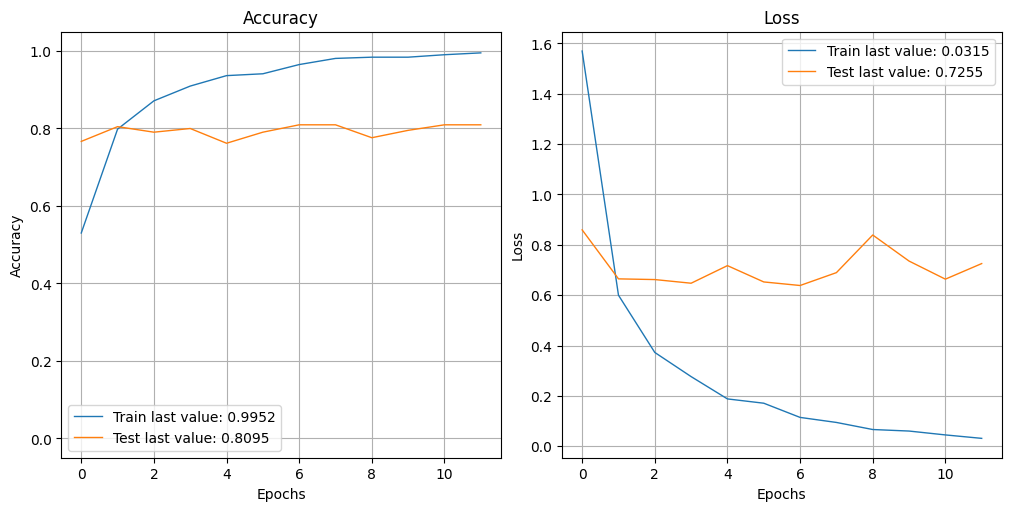

In [19]:
plot_hist(history2)

deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss. L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss.


In [20]:
y_val_num = np.argmax(y_val_mob, axis=1)
y_val_pred = np.argmax(model2.predict(X_val_mob), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step


In [21]:
conf_mat2 = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat2)

[[23  0  1  0  2  2  0]
 [ 0 20  5  2  2  0  1]
 [ 1  1 27  1  0  1  0]
 [ 2  0  0 26  1  2  0]
 [ 4  0  0  1 24  0  0]
 [ 2  0  6  1  0 23  0]
 [ 0  2  0  0  0  0 27]]


In [22]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[23  0  1  0  2  2  0]
 [ 0 20  5  2  2  0  1]
 [ 1  1 27  1  0  1  0]
 [ 2  0  0 26  1  2  0]
 [ 4  0  0  1 24  0  0]
 [ 2  0  6  1  0 23  0]
 [ 0  2  0  0  0  0 27]]

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        28
           1       0.87      0.67      0.75        30
           2       0.69      0.87      0.77        31
           3       0.84      0.84      0.84        31
           4       0.83      0.83      0.83        29
           5       0.82      0.72      0.77        32
           6       0.96      0.93      0.95        29

    accuracy                           0.81       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.81      0.81       210



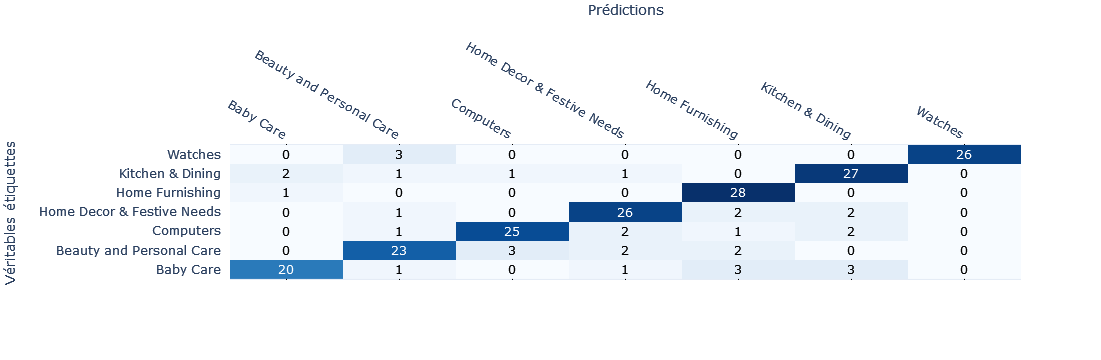

In [57]:

data = np.array(conf_mat2)  
labels = liste_cat
fig = ff.create_annotated_heatmap(data, x=labels, y=labels, colorscale='Blues')
fig.update_layout(xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()


On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Seule la catégorie Watches ne comporte aucune erreur.

# VGG16

In [58]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [59]:
X_train = list(X_train)
X_test = list(X_test)

In [60]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train, 'VGG16')
print(images_np.shape)
images_np_test = image_prep_fct(X_test,'VGG16')
print(images_np_test.shape)

(840, 224, 224, 3)


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



(210, 224, 224, 3)


In [61]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [62]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [63]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model1 = create_model_fct(model)


# Création du callback
model1_save_path1 = "models/model1_best_weights.keras"  # Modification de l'extension ici
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [64]:

# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_vgg = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_vgg))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3403 - loss: 8.9390
Epoch 1: val_loss improved from inf to 1.63741, saving model to models/model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.3502 - loss: 8.6855 - val_accuracy: 0.7238 - val_loss: 1.6374
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6849 - loss: 2.6700
Epoch 2: val_loss improved from 1.63741 to 1.23648, saving model to models/model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.6847 - loss: 2.6589 - val_accuracy: 0.7714 - val_loss: 1.2365
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7248 - loss: 1.5485
Epoch 3: val_loss improved from 1.23648 to 1.23634, saving model to models/model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 11s/step - accuracy: 0.7237 - loss: 1.5455 - val_accuracy: 0.7762 - val_loss: 1.2363
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7824 - loss: 1.0056
Epoch 4: val_loss 

In [65]:
# Scores du dernier epoch

# Évaluation du modèle sur les données d'entraînement
loss_train, accuracy_train = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train))  
print()

# Évaluation du modèle sur les données de validation
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))  


20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9980 - loss: 0.0092
Training Accuracy: 0.9984

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8682 - loss: 0.6520
Validation Accuracy: 0.8429


In [66]:
# Scores de l'epoch optimal

model1.load_weights(model1_save_path1)

loss_train_vgg, accuracy_train_vgg = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_vgg))

temps1=time.time()

loss_val_vgg, accuracy_val_vgg = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_vgg))

temps2_val_vgg = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_vgg))

temps1=time.time()

loss_test_vgg, accuracy_test_vgg = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_vgg))

temps2_test_vgg = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_vgg))

Training Accuracy: 0.9937
Validation Accuracy :  0.8095
Temps validation : 18.64 secondes
Test Accuracy       :  0.8000
Temps test : 18.69 secondes


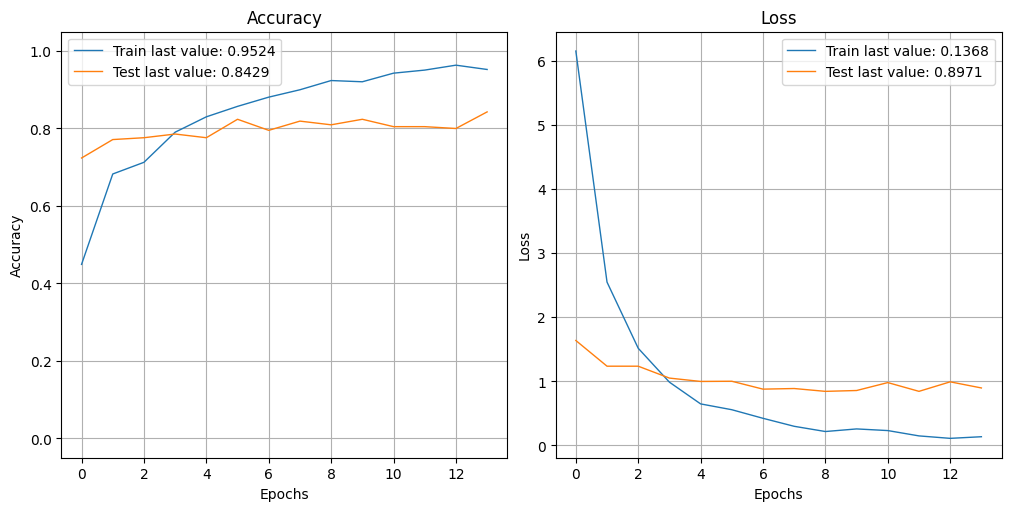

In [67]:
plot_hist(history1)

In [68]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 0 3 5 6 6 2 5 4 6 0 1 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 3 3 0 4 1 3 0
 6 2 3 1 2 4 1 4 4 4 1 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 1 5 1 2 0
 4 5 6 5 5 2 1 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 1 3 3 4 0 0 6 0 1 1 5 3 1 1 1 0 4 6 0 3 1 3 1 4 4 4 1 0 6 4 2 2 1 2 6
 0 5 5 1 4 5 5 3 2 2 3 0 5 2 3 1 2 5 1 0 5 6 1 4 1]

[0 1 0 0 2 2 0 5 5 2 3 2 2 2 2 3 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 3 2 2 4
 6 5 4 0 4 3 5 6 6 2 2 0 6 0 4 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 4 4 1 4 2 3 0
 6 2 3 1 2 0 1 4 4 0 2 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 4 1 6 0 4 3 1 2 0
 4 5 6 5 5 2 2 6 1 4 4 5 4 4 3 3 2 4 6 5 5 0 4 2 3 5 3 3 2 4 4 3 1 4 3 2 6
 5 6 3 5 1 4 0 0 6 0 1 1 5 3 1 3 1 5 4 6 2 3 1 3 1 4 4 4 1 0 2 0 2 2 1 2 6
 0 3 5 2 4 5 0 3 2 3 3 0 2 2 3 1 5 5 1 0 5 6 6 4 1]


In [69]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[22  1  1  0  3  1  0]
 [ 0 20  4  2  3  0  1]
 [ 0  2 25  2  1  1  0]
 [ 1  1  0 26  2  1  0]
 [ 4  0  0  0 25  0  0]
 [ 1  0  3  2  0 26  0]
 [ 0  0  2  1  0  0 26]]


In [70]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[22  1  1  0  3  1  0]
 [ 0 20  4  2  3  0  1]
 [ 0  2 25  2  1  1  0]
 [ 1  1  0 26  2  1  0]
 [ 4  0  0  0 25  0  0]
 [ 1  0  3  2  0 26  0]
 [ 0  0  2  1  0  0 26]]

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        28
           1       0.83      0.67      0.74        30
           2       0.71      0.81      0.76        31
           3       0.79      0.84      0.81        31
           4       0.74      0.86      0.79        29
           5       0.90      0.81      0.85        32
           6       0.96      0.90      0.93        29

    accuracy                           0.81       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.81      0.81       210



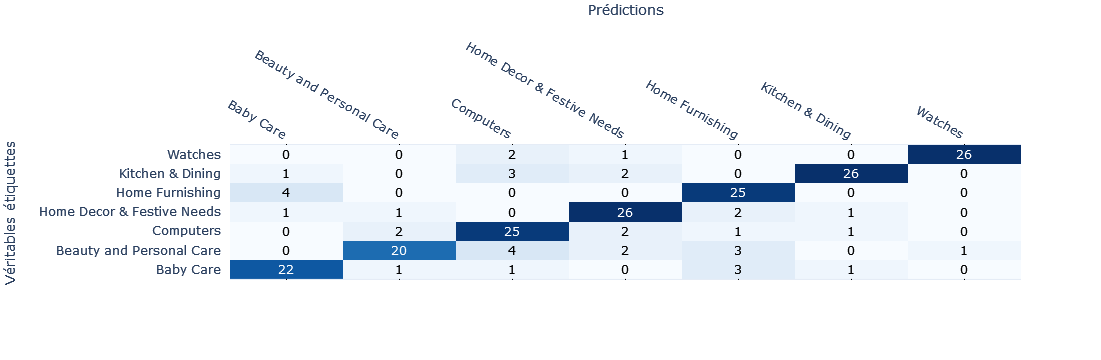

In [71]:
data = np.array(conf_mat) 
labels = liste_cat
fig = ff.create_annotated_heatmap(data, x=labels, y=labels, colorscale='Blues')
fig.update_layout( xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Il y a cependant moins d'erreurs que pour le modèle MobileNet

# Resnet50

ResNet50 (ou Residual Network) est un modèle de réseau de neurones convolutifs profonds (CNN) utilisé pour la classification d'images. La particularité de ResNet50 est qu'il utilise des connexions résiduelles qui permettent à l'information de contourner les couches intermédiaires du réseau. De la même manière que ses prédécesseurs, il a été pré-entraîné sur des millions d'images et peut être utilisé comme point de départ pour la tâche de classification d'images.

In [72]:
# Séparation du jeu de données en jeu de train et de test
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(df['image'], df['label'], test_size=0.2, random_state=0)
print(X_train_res.shape)
print(y_train_res.shape)
print(X_test_res.shape)
print(y_test_res.shape)

(840,)
(840,)
(210,)
(210,)


In [73]:
X_train_res = list(X_train_res)
X_test_res = list(X_test_res)

In [74]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train_res,'ResNet50')
print(images_np.shape)
images_np_test = image_prep_fct(X_test_res, 'ResNet50')
print(images_np_test.shape)

(840, 224, 224, 3)


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



(210, 224, 224, 3)


In [75]:
X_res = images_np
y_res = to_categorical(y_train_res)

X_test_res = images_np_test
y_test_res = to_categorical(y_test_res)

y_res

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [76]:
# Séparation du jeu de train en jeu de train et de validation
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=0)
X_train_res.shape

(630, 224, 224, 3)

In [77]:
# Création du modèle
# Charger le modèle pré-entraîné sur ImageNet, sans les couches fully-connected
model = resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model3 = create_model_fct(model)

# Création du callback
model3_save_path1 = "models/model3_resnet50_best_weights.keras"
checkpoint = ModelCheckpoint(model3_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [78]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history3 = model3.fit(X_train_res, y_train_res, epochs=50, batch_size=64, 
                      callbacks=callbacks_list, validation_data=(X_val_res, y_val_res), verbose=1)

temps2_train_res = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_res))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3465 - loss: 3.2715
Epoch 1: val_loss improved from inf to 0.64427, saving model to models/model3_resnet50_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.3580 - loss: 3.2009 - val_accuracy: 0.8143 - val_loss: 0.6443
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7756 - loss: 0.6509
Epoch 2: val_loss did not improve from 0.64427
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7748 - loss: 0.6531 - val_accuracy: 0.7381 - val_loss: 0.8195
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8157 - loss: 0.6006
Epoch 3: val_loss improved from 0.64427 to 0.59147, saving model to models/model3_resnet50_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8175 - loss: 0.5959 - val_accuracy: 0.8190 - val_loss: 0.5915
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9241 - loss: 0.2518
Epoch 4: val_loss did not improve from 0.59147
10/10 ━━━━━━━

In [79]:

# Scores du dernier epoch

loss_train, accuracy_train = model3.evaluate(X_train_res, y_train_res, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train))
print()
loss, accuracy = model3.evaluate(X_val_res, y_val_res, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 1.0000 - loss: 0.0108
Training Accuracy: 1.0000

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8501 - loss: 0.5234
Validation Accuracy:  0.8381


In [80]:
# Scores de l'epoch optimal

model3.load_weights(model3_save_path1)

loss_train_res, accuracy_train_res = model3.evaluate(X_train_res, y_train_res, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_train_res))

temps1=time.time()

loss_val_res, accuracy_val_res = model3.evaluate(X_val_res, y_val_res, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_res))

temps2_val_res = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_res))

temps1=time.time()

loss_test_res, accuracy_test_res = model3.evaluate(X_test_res, y_test_res, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_res))

temps2_test_res = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_res))

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9923 - loss: 0.0510
Training Accuracy: 0.9905
Validation Accuracy :  0.8476
Temps validation : 11.45 secondes
Test Accuracy       :  0.8476
Temps test : 11.37 secondes


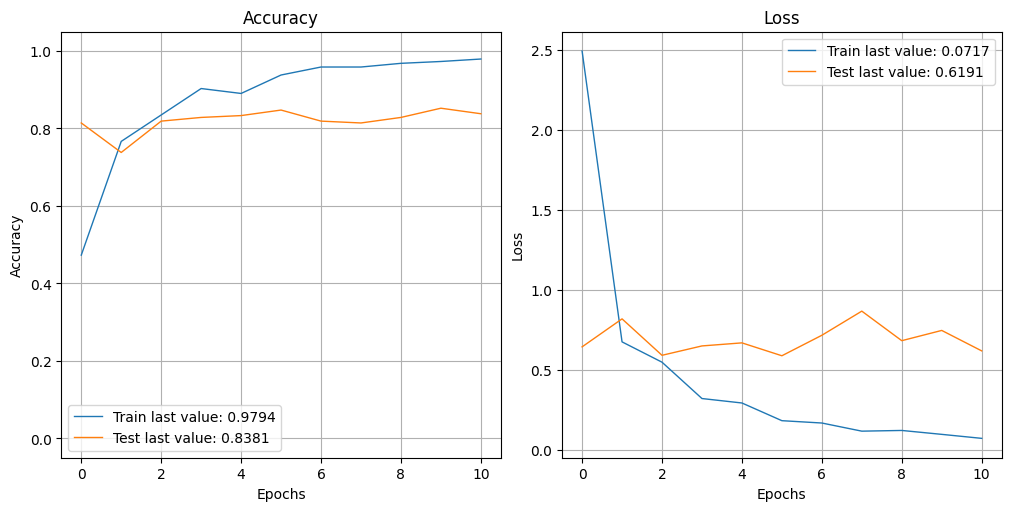

In [81]:
plot_hist(history3)

In [82]:
y_val_num = np.argmax(y_val_res, axis=1)
y_val_pred = np.argmax(model3.predict(X_val_res), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
[0 1 0 0 2 2 3 5 5 2 3 2 2 5 2 2 5 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 0 3 5 6 6 2 5 4 6 0 1 6 1 2 4 1 0 3 3 3 6 5 5 5 1 1 3 3 0 4 1 3 0
 6 2 3 1 2 4 1 4 4 4 1 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 2 6 0 1 5 1 2 0
 4 5 6 5 5 2 1 6 1 4 4 5 1 4 3 3 2 0 6 5 5 0 2 2 3 5 3 3 2 4 4 3 2 4 3 2 6
 5 6 1 3 3 4 0 0 6 0 1 1 5 3 1 1 1 0 4 6 0 3 1 3 1 4 4 4 1 0 6 4 2 2 1 2 6
 0 5 5 1 4 5 5 3 2 2 3 0 5 2 3 1 2 5 1 0 5 6 1 4 1]

[0 1 0 0 2 2 0 5 5 2 3 2 2 2 2 2 3 4 4 6 5 4 5 3 3 2 3 3 6 5 6 5 6 6 2 6 4
 6 5 4 0 4 3 5 6 6 2 5 4 6 0 4 6 1 2 4 1 0 3 5 3 6 2 3 5 1 1 3 3 1 4 2 3 0
 6 2 3 1 2 0 1 4 4 0 2 6 0 0 2 4 0 6 3 4 6 5 2 0 6 0 3 6 0 1 6 0 4 5 1 2 0
 4 5 6 3 5 2 1 6 1 4 4 5 3 4 3 3 2 0 6 5 5 0 6 2 3 5 4 3 2 4 4 3 1 4 3 2 6
 5 6 3 5 3 4 0 0 6 0 1 1 5 3 1 3 1 5 4 6 0 3 1 3 1 4 4 4 1 0 2 4 2 2 1 2 6
 5 1 5 2 4 5 5 0 2 3 3 0 5 2 5 1 2 5 1 0 5 6 2 4 1]


In [83]:
conf_mat3 = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat3)

[[24  1  0  0  1  2  0]
 [ 0 21  4  3  2  0  0]
 [ 0  2 27  1  0  0  1]
 [ 2  0  0 25  1  3  0]
 [ 2  0  0  0 27  0  0]
 [ 0  1  2  3  0 26  0]
 [ 0  0  1  0  0  0 28]]


In [84]:
y_val_pred_transform3 = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform3)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform3))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[24  1  0  0  1  2  0]
 [ 0 21  4  3  2  0  0]
 [ 0  2 27  1  0  0  1]
 [ 2  0  0 25  1  3  0]
 [ 2  0  0  0 27  0  0]
 [ 0  1  2  3  0 26  0]
 [ 0  0  1  0  0  0 28]]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.84      0.70      0.76        30
           2       0.79      0.87      0.83        31
           3       0.78      0.81      0.79        31
           4       0.87      0.93      0.90        29
           5       0.84      0.81      0.83        32
           6       0.97      0.97      0.97        29

    accuracy                           0.85       210
   macro avg       0.85      0.85      0.85       210
weighted avg       0.85      0.85      0.85       210



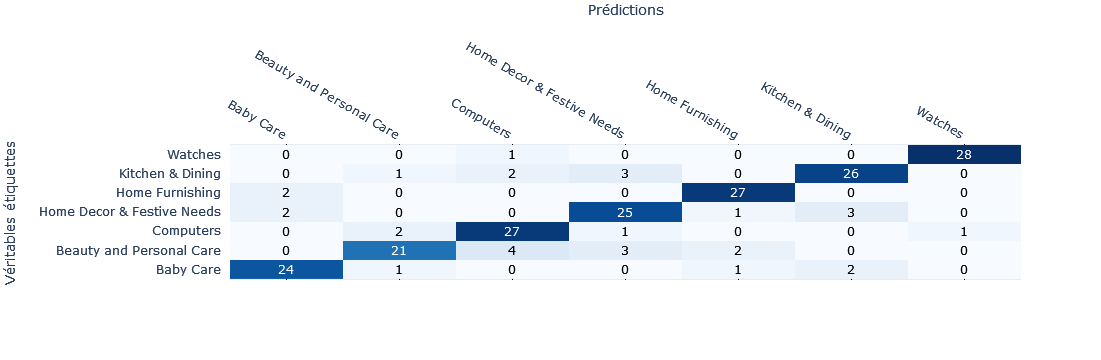

In [85]:
data = np.array(conf_mat) 
labels = liste_cat
fig = ff.create_annotated_heatmap(data, x=labels, y=labels, colorscale='Blues')
fig.update_layout( xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()

On constate que le modèle arrive à prédire relativement bien les catégories. En revanche, il y a des erreurs. Certaines images sont mal catégorisées. Il y a cependant plus d'erreurs que pour le modèle VGG16 pour certaines catégories.

Comparons désormais les différents modèles entraînés afin de sélectionner le plus pertiennt pour notre étude

In [86]:
tab_models_recap = pd.DataFrame({'Accuracy training':[accuracy_train_vgg, accuracy_train_mob, accuracy_train_res],
                                 'Accuracy validation': [accuracy_val_vgg, accuracy_val_mob, accuracy_val_res],
                                 'Accuracy test': [accuracy_test_vgg, accuracy_test_mob, accuracy_test_res],
                                 'Loss training':[loss_train_vgg, loss_train_mob, loss_train_res],
                                 'Loss validation': [loss_val_vgg, loss_val_mob, loss_val_res],
                                 'Loss test': [loss_test_vgg, loss_test_mob, loss_test_res],
                                 'Temps train': [temps2_train_vgg, temps2_train_mob, temps2_train_res],
                                 'Temps validation': [temps2_val_vgg, temps2_val_mob, temps2_val_res],
                                 'Temps test': [temps2_test_vgg, temps2_test_mob, temps2_test_res]},
                                index = ['VGG16','MobileNet','Resnet50'])

In [87]:
tab_models_recap

,Accuracy training,Accuracy validation,Accuracy test,Loss training,Loss validation,Loss test,Temps train,Temps validation,Temps test
VGG16,0.993651,0.809524,0.800000,0.023969,0.822871,1.041434,1567.18,18.64,18.69
MobileNet,0.980952,0.833333,0.804762,0.111231,0.601045,0.646867,105.99,2.68,2.80
Resnet50,0.990476,0.847619,0.847619,0.050840,0.566071,0.560538,453.23,11.45,11.37


# Optimisation du modèle choisi

Nous allons optimiser le modèle VGG16 en ajustant certains paramètres pour améliorer ses performances. Nous testerons différentes valeurs pour l’optimiseur, la fonction de perte (loss) et la taille de lot (batch size).

Un optimiseur est un algorithme qui ajuste les paramètres du modèle pour minimiser la fonction de perte, en utilisant des techniques de descente de gradient. Nous expérimenterons avec :

‘rmsprop’ : qui adapte la taille du pas de gradient pour chaque paramètre de manière adaptative, basée sur l’historique des gradients.
‘adam’ : qui, comme RMSprop, utilise une moyenne mobile des gradients pour ajuster le taux d’apprentissage, mais ajoute aussi une moyenne mobile de la racine carrée des carrés des gradients passés, offrant une correction de biais pour les moments de premier et second ordre.
La fonction de perte mesure l’écart entre les prédictions du modèle et les valeurs réelles. Pour un problème de classification multi-classes, nous testerons :

‘categorical_crossentropy’ : qui calcule l’entropie croisée entre la distribution de probabilité réelle et celle prédite.
‘categorical_hinge’ : qui est une extension de la fonction de perte ‘hinge’ pour la classification multi-classes, calculant la différence entre la somme des valeurs prédites pour la classe correcte et la plus grande valeur prédite pour les autres classes, plus un terme de marge.
Le batch size détermine le nombre d’échantillons traités par itération d’entraînement. Nous testerons les tailles de 32, 64 et 128 pour trouver l’équilibre optimal entre la précision de l’apprentissage et l’efficacité de la mémoire.

In [90]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [91]:
X_train = list(X_train)
X_test = list (X_test)

In [92]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train, 'VGG16')
print(images_np.shape)
images_np_test = image_prep_fct(X_test,'VGG16')
print(images_np_test.shape)

(840, 224, 224, 3)


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



(210, 224, 224, 3)


In [93]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

In [94]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [96]:
# Création du modèle
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Création du callback
model1_opti_save_path1 = "models/model1_opti_vgg16_best_weights.keras"
checkpoint = ModelCheckpoint(model1_opti_save_path1, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

In [97]:
loss_param = []
batch_param = []
opti_param = []
temps_train = []
temps_val = []
loss_train = []
loss_val = []
accuracy_train = []
accuracy_val = []

np.random.seed(42)

for opti in ['rmsprop','adam']:
    for loss in ['categorical_crossentropy', 'categorical_hinge']:
        for batch_size in [32, 64, 128]:
        
            loss_param.append(loss)
            batch_param.append(batch_size)
            opti_param.append(opti)
        
            model_opti = create_model_fct(model, loss, opti, option = False)

            temps1=time.time()
            
            history_opti = model_opti.fit(X_train, y_train, epochs=50,
                                          callbacks=callbacks_list,
                                          validation_data=(X_val, y_val),
                                          verbose=0
                                         )

            temps2_train_opti = np.round(time.time()-temps1, 2)
            temps_train.append(temps2_train_opti)
        
            model_opti.load_weights(model1_opti_save_path1)

            loss_train_opti, accuracy_train_opti = model_opti.evaluate(X_train, y_train, verbose=False)
            loss_train.append(loss_train_opti)
            accuracy_train.append(accuracy_train_opti)
        
            temps1=time.time()

            loss_val_opti, accuracy_val_opti = model_opti.evaluate(X_val, y_val, verbose=False)
            loss_val.append(loss_val_opti)
            accuracy_val.append(accuracy_val_opti)

            temps2_val_opti = np.round(time.time()-temps1, 2)
            temps_val.append(temps2_val_opti)

            print('Test avec les paramètres {}, {} et {} réalisé.'.format(loss,batch_size,opti))

Test avec les paramètres categorical_crossentropy, 32 et rmsprop réalisé.
Test avec les paramètres categorical_crossentropy, 64 et rmsprop réalisé.
Test avec les paramètres categorical_crossentropy, 128 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 32 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 64 et rmsprop réalisé.
Test avec les paramètres categorical_hinge, 128 et rmsprop réalisé.


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 6 variables. 



Test avec les paramètres categorical_crossentropy, 32 et adam réalisé.
Test avec les paramètres categorical_crossentropy, 64 et adam réalisé.
Test avec les paramètres categorical_crossentropy, 128 et adam réalisé.
Test avec les paramètres categorical_hinge, 32 et adam réalisé.
Test avec les paramètres categorical_hinge, 64 et adam réalisé.
Test avec les paramètres categorical_hinge, 128 et adam réalisé.


In [98]:
tab_recap_opti = pd.DataFrame({'Accuracy entrainement': accuracy_train,
                               'Accuracy validation': accuracy_val,
                               'Loss entrainement': loss_train,
                               'Loss validation': loss_val,
                               'Temps train': temps_train,
                               'Temps validation': temps_val,
                               'Loss parameter': loss_param,
                               'Batch parameter': batch_param,
                               'Optimizer parameter':opti_param
                              })
tab_recap_opti

,Accuracy entrainement,Accuracy validation,Loss entrainement,Loss validation,Temps train,Temps validation,Loss parameter,Batch parameter,Optimizer parameter
0,0.947619,0.838095,0.212824,0.833518,973.09,28.65,categorical_crossentropy,32,rmsprop
1,0.947619,0.838095,0.212824,0.833518,560.31,26.47,categorical_crossentropy,64,rmsprop
2,0.947619,0.838095,0.212824,0.833518,535.32,36.29,categorical_crossentropy,128,rmsprop
3,0.928571,0.833333,0.140123,0.336009,3784.32,26.39,categorical_hinge,32,rmsprop
4,0.928571,0.833333,0.140123,0.336009,535.03,26.47,categorical_hinge,64,rmsprop
5,0.928571,0.833333,0.140123,0.336009,564.58,26.83,categorical_hinge,128,rmsprop
6,0.928571,0.833333,1.879110,2.542833,536.69,28.47,categorical_crossentropy,32,adam
7,0.928571,0.833333,1.879110,2.542833,542.21,26.49,categorical_crossentropy,64,adam
8,0.928571,0.833333,1.879110,2.542833,532.43,39.04,categorical_crossentropy,128,adam
9,0.928571,0.833333,0.140123,0.336009,768.16,35.54,categorical_hinge,32,adam


On selectionne le modèle ayant l'accuracy de validation la plus élevé, la loss de validation la plus faible et le temps d'entraînement le plus court possible. Cela revient donc à sélectionner le modèle avec les paramètres suivants : loss = 'categorical_hinge'et optimizer = 'adam'.

In [100]:
# Création du modèle
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model_fin = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_final_save_path1 = "models/model_final_vgg_best_weights.keras"
checkpoint = ModelCheckpoint(model_final_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_18          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [101]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history_final = model_fin.fit(X_train, y_train, epochs=50, batch_size=128, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_res = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_res))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.1509 - loss: 1.6158 
Epoch 1: val_loss improved from inf to 1.55197, saving model to models/model_final_vgg_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 122s 26s/step - accuracy: 0.1527 - loss: 1.6140 - val_accuracy: 0.1810 - val_loss: 1.5520
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.1704 - loss: 1.5942 
Epoch 2: val_loss improved from 1.55197 to 1.37151, saving model to models/model_final_vgg_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 23s/step - accuracy: 0.1761 - loss: 1.5836 - val_accuracy: 0.2857 - val_loss: 1.3715
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2896 - loss: 1.3691 
Epoch 3: val_loss improved from 1.37151 to 1.24810, saving model to models/model_final_vgg_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 23s/step - accuracy: 0.2906 - loss: 1.3664 - val_accuracy: 0.3381 - val_loss: 1.2481
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3727 - loss: 1.207

In [102]:
# Scores du dernier epoch

loss, accuracy = model_fin.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_fin.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8989 - loss: 0.2009
Training Accuracy: 0.9000

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8346 - loss: 0.3360
Validation Accuracy:  0.8048


In [103]:
# Scores de l'epoch optimal

model_fin.load_weights(model_final_save_path1)

loss_train_fin, accuracy_train_fin = model_fin.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_fin))

temps1=time.time()

loss_val_fin, accuracy_val_fin = model_fin.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_fin))

temps2_val_fin = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_fin))

temps1=time.time()

loss_test_fin, accuracy_test_fin = model_fin.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_fin))

temps2_test_fin = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_fin))

Training Accuracy: 0.8905
Validation Accuracy :  0.8333
Temps validation : 21.56 secondes
Test Accuracy       :  0.7762
Temps test : 22.37 secondes


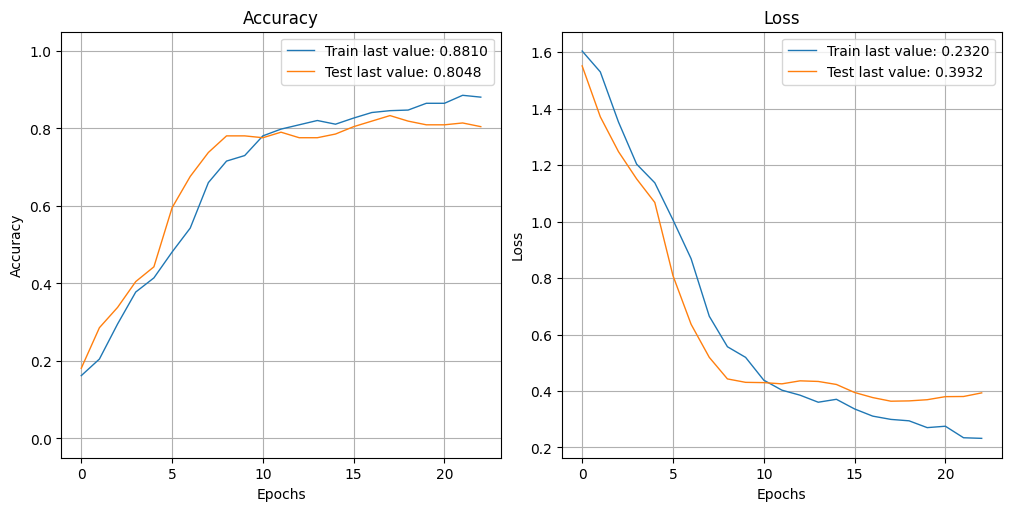

In [104]:
plot_hist(history_final)

On collecte l'historique renvoyé par l'entraînement du modèle et on crée deux graphiques : l'un représentant l'accuracy sur les ensembles de données de training et de validation sur les différents epochs, et l'autre similaire mais pour la loss. L'objectif étant pour chaque modèle de maximiser l'accuracy tout en diminuant la loss.


In [105]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_fin.predict(X_val), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


In [106]:
conf_mat_fin = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat_fin)

[[22  1  0  1  1  3  0]
 [ 1 19  4  2  2  2  0]
 [ 0  0 27  2  0  1  1]
 [ 1  0  0 27  0  3  0]
 [ 3  0  0  0 26  0  0]
 [ 0  2  1  2  0 27  0]
 [ 0  0  1  1  0  0 27]]


In [108]:

y_val_pred_transform3 = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform3)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform3))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[22  1  0  1  1  3  0]
 [ 1 19  4  2  2  2  0]
 [ 0  0 27  2  0  1  1]
 [ 1  0  0 27  0  3  0]
 [ 3  0  0  0 26  0  0]
 [ 0  2  1  2  0 27  0]
 [ 0  0  1  1  0  0 27]]

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.86      0.63      0.73        30
           2       0.82      0.87      0.84        31
           3       0.77      0.87      0.82        31
           4       0.90      0.90      0.90        29
           5       0.75      0.84      0.79        32
           6       0.96      0.93      0.95        29

    accuracy                           0.83       210
   macro avg       0.84      0.83      0.83       210
weighted avg       0.84      0.83      0.83       210



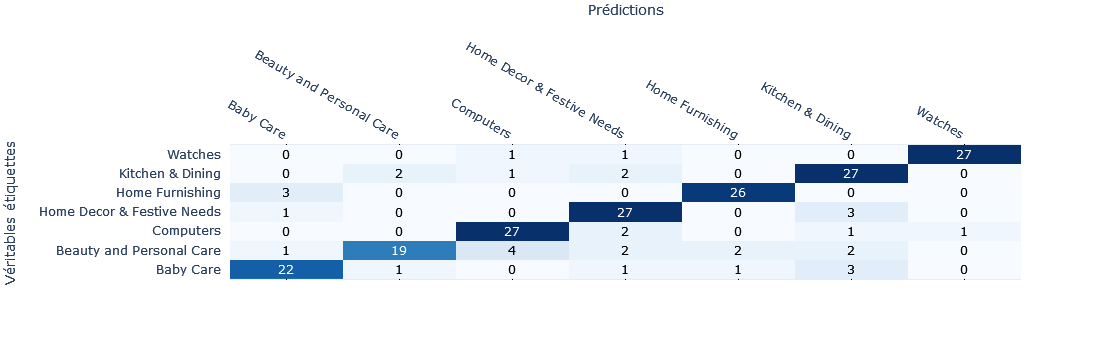

In [109]:
data = np.array(conf_mat) 
labels = liste_cat
fig = ff.create_annotated_heatmap(data, x=labels, y=labels, colorscale='Blues')
fig.update_layout( xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()

# Data Augmentation

La data augmentation est une stratégie pour augmenter la diversité des données disponibles pour l’entraînement des modèles sans collecter de nouvelles données. Elle implique l’application de transformations variées aux données existantes, comme la rotation ou le changement de luminosité pour les images, ce qui peut aider à améliorer la généralisation du modèle et à prévenir le surajustement.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [111]:
data = pd.concat([X_train,y_train],axis=1)
data['label'] = data['label'].astype(str)
data_test = pd.concat([X_test,y_test],axis=1)
data_test['label'] = data_test['label'].astype(str)

# Images avec rotation

In [113]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_rot = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_rot_save_path = "models/model_data_rot_best_weights.keras"
checkpoint = ModelCheckpoint(model_data_rot_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_20          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [114]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(rotation_range=30, 
                                   fill_mode='nearest',
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [115]:
temps1=time.time()

history_rotation = model_data_rot.fit(train_flow, validation_data=val_flow,
                                      batch_size=batch_size, epochs=50, 
                                      callbacks=callbacks_list, verbose=1)

temps2_train_rot = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_rot))

Epoch 1/50


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2001 - loss: 1.5242 
Epoch 1: val_loss improved from inf to 1.36109, saving model to models/model_data_rot_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 18s/step - accuracy: 0.2035 - loss: 1.5178 - val_accuracy: 0.2905 - val_loss: 1.3611
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2836 - loss: 1.3767 
Epoch 2: val_loss improved from 1.36109 to 1.25508, saving model to models/model_data_rot_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 16s/step - accuracy: 0.2871 - loss: 1.3700 - val_accuracy: 0.3333 - val_loss: 1.2551
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4071 - loss: 1.1712 
Epoch 3: val_loss improved from 1.25508 to 1.20167, saving model to models/model_data_rot_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 15s/step - accuracy: 0.4035 - loss: 1.1773 - val_accuracy: 0.3810 - val_loss: 1.2017
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4193 - loss: 1.1281 
Epoch 4: val_

In [116]:
# Scores du dernier epoch

loss_train, accuracy_train = model_data_rot.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_rot.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 11s/step - accuracy: 0.9431 - loss: 0.1136
Training Accuracy   : 0.9317
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.7958 - loss: 0.4050
Validation Accuracy :  0.7952


In [117]:
# Scores de l'epoch optimal

model_data_rot.load_weights(model_data_rot_save_path)

loss_train_rot, accuracy_train_rot = model_data_rot.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_rot))

temps1=time.time()
loss_val_rot, accuracy_val_rot = model_data_rot.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_rot))
temps2_val_rot = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_rot))

temps1=time.time()
loss_test_rot, accuracy_test_rot = model_data_rot.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_rot))
temps2_test_rot = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_rot))

Training Accuracy   : 0.9206
Validation Accuracy :  0.8238
Temps de validation : 22.5 secondes


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



Test Accuracy       :  0.7952
Temps de test : 22.74 secondes


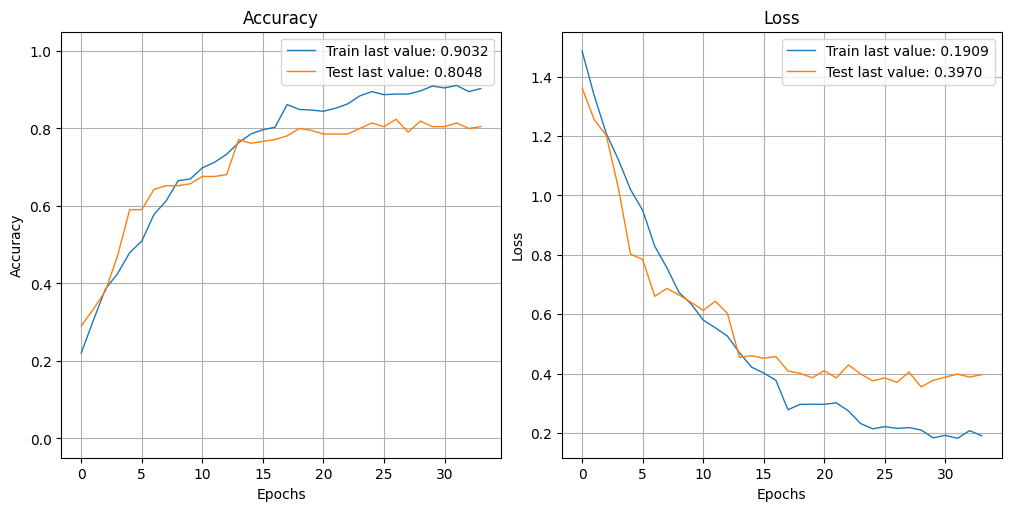

In [118]:
plot_hist(history_rotation)

# Images avec shift

In [120]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_shift = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_shift_save_path = "models/model_data_shift_best_weights.keras"
checkpoint = ModelCheckpoint(model_data_shift_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_22          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [121]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,
                                  preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [122]:
temps1=time.time()

history_shift = model_data_shift.fit(train_flow, validation_data=val_flow,
                                     batch_size=batch_size, epochs=50, 
                                     callbacks=callbacks_list, verbose=1)

temps2_train_shi = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_shi))

Epoch 1/50


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1883 - loss: 1.5333 
Epoch 1: val_loss improved from inf to 1.30753, saving model to models/model_data_shift_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - accuracy: 0.1921 - loss: 1.5270 - val_accuracy: 0.2952 - val_loss: 1.3075
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3209 - loss: 1.2723 
Epoch 2: val_loss improved from 1.30753 to 0.88546, saving model to models/model_data_shift_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 16s/step - accuracy: 0.3264 - loss: 1.2612 - val_accuracy: 0.5333 - val_loss: 0.8855
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4630 - loss: 1.0329 
Epoch 3: val_loss improved from 0.88546 to 0.74871, saving model to models/model_data_shift_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - accuracy: 0.4668 - loss: 1.0257 - val_accuracy: 0.6143 - val_loss: 0.7487
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5713 - loss: 0.8393 
Epoch 4:

In [123]:
# Score du dernier epoch

loss_train, accuracy_train = model_data_shift.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_shift.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step - accuracy: 0.8990 - loss: 0.2080
Training Accuracy   : 0.8921
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.7975 - loss: 0.3835
Validation Accuracy :  0.8095


In [124]:

# Score de l'epoch optimal

model_data_shift.load_weights(model_data_shift_save_path)

loss_train_shi, accuracy_train_shi = model_data_shift.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_shi))

temps1=time.time()
loss_val_shi, accuracy_val_shi = model_data_shift.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_shi))
temps2_val_shi = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_shi))

temps1=time.time()
loss_test_shi, accuracy_test_shi = model_data_shift.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_shi))
temps2_test_shi = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_shi))

Training Accuracy   : 0.8683
Validation Accuracy :  0.7810
Temps de validation : 24.93 secondes


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



Test Accuracy       :  0.7714
Temps de test : 23.78 secondes


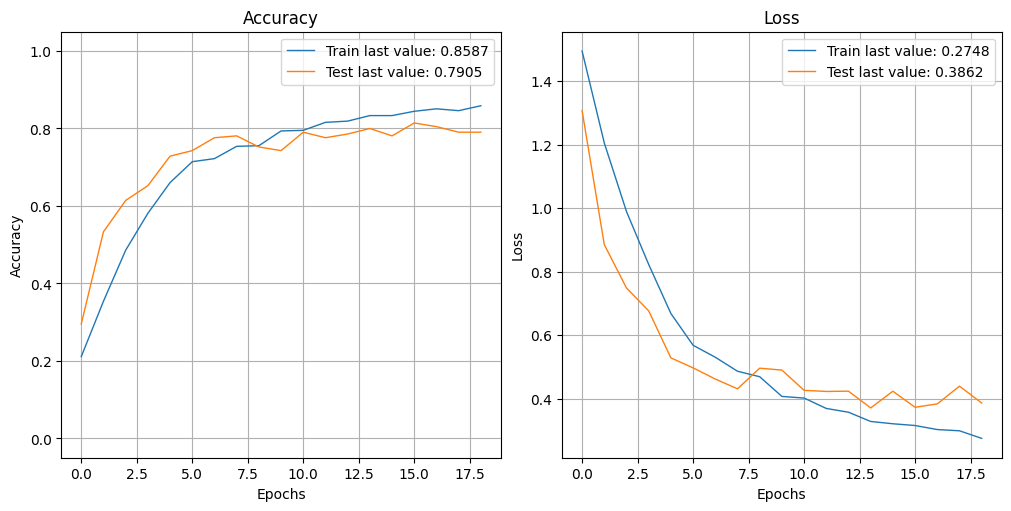

In [125]:
plot_hist(history_shift)

# Images avec zoom

In [127]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_zoom = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_zoom_save_path = "models/model_data_zoom_best_weights.keras"
checkpoint = ModelCheckpoint(model_data_zoom_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_24          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [128]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(zoom_range=0.3,
                                   validation_split=0.25,
                                   preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [129]:
temps1=time.time()

history_zoom = model_data_zoom.fit(train_flow, validation_data=val_flow,
                                   batch_size=batch_size, epochs=50, 
                                   callbacks=callbacks_list, verbose=1)

temps2_train_zoom = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_zoom))

Epoch 1/50


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1580 - loss: 1.5894 
Epoch 1: val_loss improved from inf to 1.43745, saving model to models/model_data_zoom_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 18s/step - accuracy: 0.1624 - loss: 1.5826 - val_accuracy: 0.2619 - val_loss: 1.4375
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2494 - loss: 1.4572 
Epoch 2: val_loss improved from 1.43745 to 1.20069, saving model to models/model_data_zoom_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 17s/step - accuracy: 0.2541 - loss: 1.4485 - val_accuracy: 0.3810 - val_loss: 1.2007
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3384 - loss: 1.2748 
Epoch 3: val_loss improved from 1.20069 to 0.95199, saving model to models/model_data_zoom_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 17s/step - accuracy: 0.3415 - loss: 1.2691 - val_accuracy: 0.5048 - val_loss: 0.9520
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4406 - loss: 1.0857 
Epoch 4: va

In [132]:
# Scores du dernier epoch

loss_train, accuracy_train = model_data_zoom.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))

loss, accuracy = model_data_zoom.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 106s 20s/step - accuracy: 0.9407 - loss: 0.1172
Training Accuracy   : 0.9286
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 13s/step - accuracy: 0.8258 - loss: 0.3480
Validation Accuracy :  0.8286


In [134]:
# Scores de l'epoch optimal

model_data_zoom.load_weights(model_data_zoom_save_path)

loss_train_zoom, accuracy_train_zoom = model_data_zoom.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_zoom))

temps1=time.time()
loss_val_zoom, accuracy_val_zoom = model_data_zoom.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_zoom))
temps2_val_zoom = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_zoom))

temps1=time.time()
loss_test_zoom, accuracy_test_zoom = model_data_zoom.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_zoom))
temps2_test_zoom = np.round(time.time()-temps1, 2)
print("Temps de test : {} secondes".format(temps2_test_zoom))

Training Accuracy   : 0.9317
Validation Accuracy :  0.8381
Temps de validation : 37.73 secondes


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



Test Accuracy       :  0.8095
Temps de test : 36.39 secondes


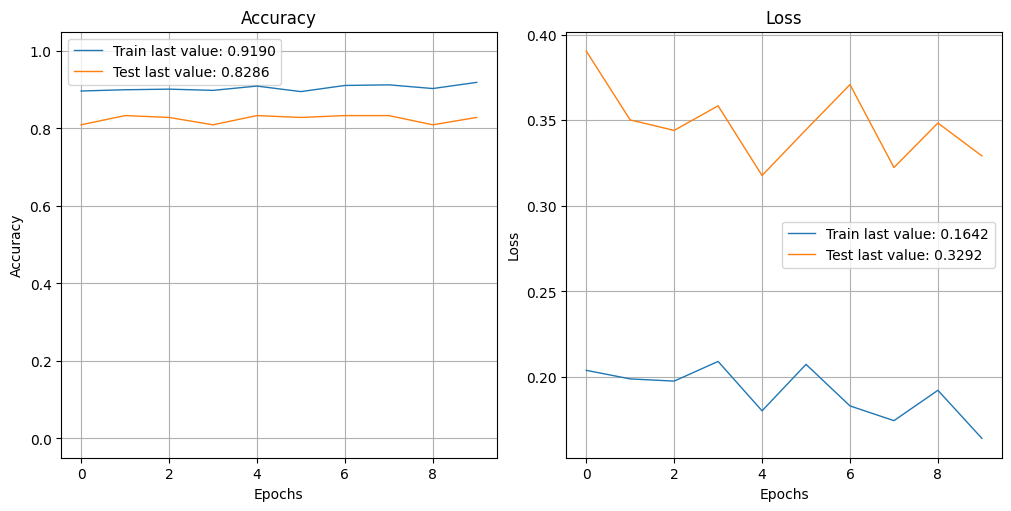

In [135]:
plot_hist(history_zoom)

In [136]:
# Images avec plusieurs transformations

In [138]:
# Création du modèle
batch_size = 128
model = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_data_gen_all = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_data_gen_all_save_path = "models/model_data_gen_all_best_weights.keras"
checkpoint = ModelCheckpoint(model_data_gen_all_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_26          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [139]:
# Indication de la transformation désirée et création des nouvelles données.
datagen_train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    validation_split=0.25,
    preprocessing_function=vgg16.preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=vgg16.preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [140]:
temps1=time.time()

history_gen = model_data_gen_all.fit(train_flow, validation_data=val_flow,
                                     batch_size=batch_size, epochs=50, 
                                     callbacks=callbacks_list, verbose=1)

temps2_train_all = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_all))

Epoch 1/50


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.2108 - loss: 1.5052 
Epoch 1: val_loss improved from inf to 1.38885, saving model to models/model_data_gen_all_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 166s 30s/step - accuracy: 0.2124 - loss: 1.4995 - val_accuracy: 0.2381 - val_loss: 1.3888
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.2877 - loss: 1.3239 
Epoch 2: val_loss improved from 1.38885 to 1.10497, saving model to models/model_data_gen_all_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 150s 28s/step - accuracy: 0.2916 - loss: 1.3190 - val_accuracy: 0.3952 - val_loss: 1.1050
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4057 - loss: 1.1383 
Epoch 3: val_loss improved from 1.10497 to 0.99695, saving model to models/model_data_gen_all_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 27s/step - accuracy: 0.4082 - loss: 1.1332 - val_accuracy: 0.4714 - val_loss: 0.9970
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4832 - loss: 1.0029 

In [141]:
# Score du dernier epoch

loss, accuracy = model_data_gen_all.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_data_gen_all.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 98s 18s/step - accuracy: 0.8836 - loss: 0.2234
Training Accuracy   : 0.8937

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 11s/step - accuracy: 0.8131 - loss: 0.3862
Validation Accuracy :  0.8095


In [142]:
# Score de l'epoch optimal

model_data_gen_all.load_weights(model_data_gen_all_save_path)

loss_train_all, accuracy_train_all = model_data_gen_all.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy_train_all))

temps1=time.time()
loss_val_all, accuracy_val_all = model_data_gen_all.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_all))
temps2_val_all = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_val_all))

temps1=time.time()
loss_test_all, accuracy_test_all = model_data_gen_all.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_all))
temps2_test_all = np.round(time.time()-temps1, 2)
print("Temps de validation : {} secondes".format(temps2_test_all))

Training Accuracy   : 0.8762
Validation Accuracy :  0.7905
Temps de validation : 32.71 secondes


C:\Users\imane.elhabachi\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



Test Accuracy       :  0.8000
Temps de validation : 32.15 secondes


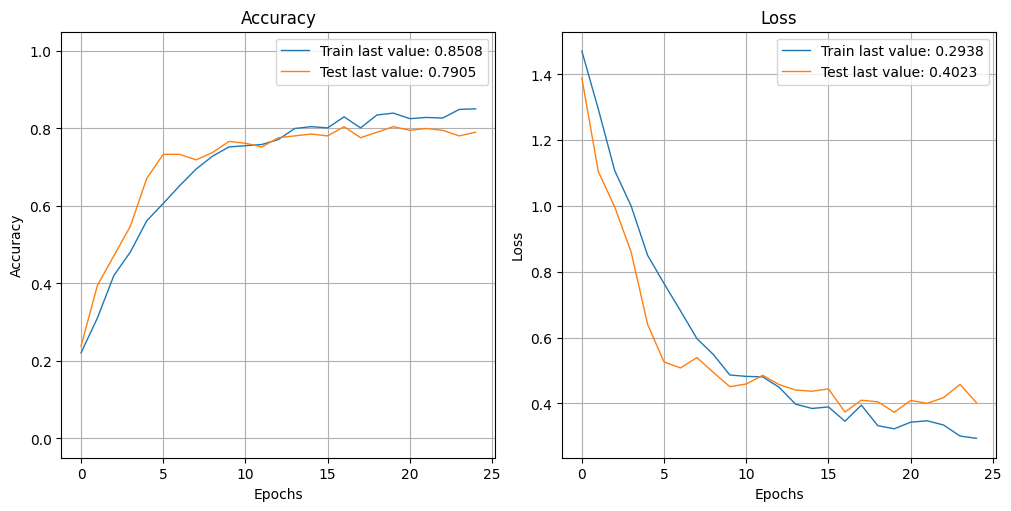

In [143]:
plot_hist(history_gen)

In [145]:
tab_augm_recap = pd.DataFrame({'Accuracy training':[accuracy_train_fin, accuracy_train_rot, accuracy_train_shi, accuracy_train_zoom, accuracy_train_all],
                                 'Accuracy validation': [accuracy_val_fin, accuracy_val_rot, accuracy_val_shi, accuracy_val_zoom, accuracy_val_all],
                                 'Accuracy test': [accuracy_test_fin, accuracy_test_rot, accuracy_test_shi, accuracy_test_zoom, accuracy_test_all],
                                 'Loss training':[loss_train_fin, loss_train_rot, loss_train_shi, loss_train_zoom, loss_train_all],
                                 'Loss validation': [loss_val_fin, loss_val_rot, loss_val_shi, loss_val_zoom, loss_val_all],
                                 'Loss test': [loss_test_fin, loss_test_rot, loss_test_shi, loss_test_zoom, loss_test_all],
                                 'Temps train': [temps2_train_res, temps2_train_rot, temps2_train_shi, temps2_train_zoom, temps2_train_all],
                                 'Temps validation': [temps2_val_fin, temps2_val_rot, temps2_val_shi, temps2_val_zoom, temps2_val_all],
                                 'Temps test': [temps2_test_fin, temps2_test_rot, temps2_test_shi, temps2_test_zoom, temps2_test_all]},
                                index = ['Modèle de base','Rotation','Shift','Zoom','Multiples'])
tab_augm_recap

,Accuracy training,Accuracy validation,Accuracy test,Loss training,Loss validation,Loss test,Temps train,Temps validation,Temps test
Modèle de base,0.890476,0.833333,0.776190,0.218520,0.366158,0.447986,2453.52,21.56,22.37
Rotation,0.920635,0.823810,0.795238,0.155638,0.385359,0.406187,3231.30,22.50,22.74
Shift,0.868254,0.780952,0.771429,0.264347,0.404619,0.452657,2362.52,24.93,23.78
Zoom,0.931746,0.838095,0.809524,0.143964,0.326165,0.374979,1488.18,37.73,36.39
Multiples,0.876190,0.790476,0.800000,0.252806,0.416796,0.387516,4101.90,32.71,32.15
